# Recognizing Human Activities using Smartphones
## Classification on Smartphone-Based Recognition of Human Activities and Postural Transitions Dataset

In [78]:
# load packages
library(repr)
library(knitr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

# set the seed
set.seed(1)

In [1]:
# Data source: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions#
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

# Specifying destination where file should be saved
destfile <- "data/localfile.zip"

# Apply download.file function 
download.file(url, destfile)

# unzip the downloaded file
unzip ("data/localfile.zip", exdir = "data/")

In [3]:
# create a vector of features to use for col names of training set
# X1 represents the row number
# X2 is the features
features_table <- read_delim("data/UCI HAR Dataset/features.txt", delim = " ", col_names = FALSE)
glimpse(features_table)
features_vector <- dplyr::pull(features_table, 'X2')
features_vector_sub <- gsub("-", "_", features_vector)

features_vector_sub <- gsub("[()]", "", features_vector_sub)
glimpse(features_vector_sub)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_character()
)



Rows: 561
Columns: 2
$ X1 <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…
$ X2 <chr> "tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z", "tB…
 chr [1:561] "tBodyAcc_mean_X" "tBodyAcc_mean_Y" "tBodyAcc_mean_Z" ...


In [4]:
# create a table of activity labels to add such a variable as a column into the training set data frame.
label_col_name_vec <- c('activity_label')
y_training_label <- read_delim("data/UCI HAR Dataset/train/y_train.txt", delim = " ", col_names = label_col_name_vec) 

y_testing_label <- read_delim("data/UCI HAR Dataset/test/y_test.txt", delim = " ", col_names = label_col_name_vec) 

Parsed with column specification:
cols(
  activity_label = col_double()
)

Parsed with column specification:
cols(
  activity_label = col_double()
)



In [20]:
# read feature values 
x_training_data <- read_delim("data/UCI HAR Dataset/train/X_train.txt", delim = " ", col_names = features_vector_sub)

x_testing_data <- read_delim("data/UCI HAR Dataset/test/X_test.txt", delim = " ", col_names = features_vector_sub)

Warning message:
“Duplicated column names deduplicated: 'fBodyAcc_bandsEnergy_1,8' => 'fBodyAcc_bandsEnergy_1,8_1' [317], 'fBodyAcc_bandsEnergy_9,16' => 'fBodyAcc_bandsEnergy_9,16_1' [318], 'fBodyAcc_bandsEnergy_17,24' => 'fBodyAcc_bandsEnergy_17,24_1' [319], 'fBodyAcc_bandsEnergy_25,32' => 'fBodyAcc_bandsEnergy_25,32_1' [320], 'fBodyAcc_bandsEnergy_33,40' => 'fBodyAcc_bandsEnergy_33,40_1' [321], 'fBodyAcc_bandsEnergy_41,48' => 'fBodyAcc_bandsEnergy_41,48_1' [322], 'fBodyAcc_bandsEnergy_49,56' => 'fBodyAcc_bandsEnergy_49,56_1' [323], 'fBodyAcc_bandsEnergy_57,64' => 'fBodyAcc_bandsEnergy_57,64_1' [324], 'fBodyAcc_bandsEnergy_1,16' => 'fBodyAcc_bandsEnergy_1,16_1' [325], 'fBodyAcc_bandsEnergy_17,32' => 'fBodyAcc_bandsEnergy_17,32_1' [326], 'fBodyAcc_bandsEnergy_33,48' => 'fBodyAcc_bandsEnergy_33,48_1' [327], 'fBodyAcc_bandsEnergy_49,64' => 'fBodyAcc_bandsEnergy_49,64_1' [328], 'fBodyAcc_bandsEnergy_1,24' => 'fBodyAcc_bandsEnergy_1,24_1' [329], 'fBodyAcc_bandsEnergy_25,48' => 'fBodyAcc_ba

In [21]:
# add activity label column to data
training_set_all <- bind_cols(x_training_data, y_training_label)
tail(training_set_all)

testing_set_all <- bind_cols(x_testing_data, y_testing_label)
tail(testing_set_all)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2.3796648e-001,-1.0878070e-003,-1.4832590e-001,-2.1894876e-001,-1.2926748e-002,1.7001874e-001,-3.0959929e-001,-4.1392263e-002,2.0745436e-001,2.1079544e-001,⋯,-5.9248831e-001,-8.6723607e-001,3.5277575e-001,-6.0481685e-001,-7.7478312e-001,7.3014246e-001,-7.9727183e-001,2.3499575e-001,4.8907023e-002,2
2.9966534e-001,-5.7193414e-002,-1.8123302e-001,-1.9538652e-001,3.9904850e-002,7.7078081e-002,-2.8230064e-001,4.3615631e-002,6.0410083e-002,2.1079544e-001,⋯,-5.8843274e-001,-8.8032443e-001,-1.9043686e-001,8.2971842e-001,2.0697215e-001,-4.2561858e-001,-7.9188305e-001,2.3860439e-001,4.9819139e-002,2
2.7385271e-001,-7.7493259e-003,-1.4746837e-001,-2.3530853e-001,4.8162805e-003,5.9279994e-002,-3.2255234e-001,-2.9456250e-002,8.0585116e-002,1.1744028e-001,⋯,-3.9073832e-001,-6.8074445e-001,6.4906712e-002,8.7567905e-001,-8.7903279e-001,4.0021936e-001,-7.7183960e-001,2.5267595e-001,5.0052558e-002,2
2.7338737e-001,-1.7010616e-002,-4.5021828e-002,-2.1821818e-001,-1.0382198e-001,2.7453270e-001,-3.0451515e-001,-9.8913034e-002,3.3258449e-001,4.3998772e-002,⋯,2.5145333e-002,-3.0402936e-001,5.2805928e-002,-2.6672437e-001,8.6440401e-001,7.0116882e-001,-7.7913261e-001,2.4914484e-001,4.0811188e-002,2
2.8965416e-001,-1.8843044e-002,-1.5828059e-001,-2.1913944e-001,-1.1141169e-001,2.6889320e-001,-3.1048749e-001,-6.8200325e-002,3.1947326e-001,1.0170184e-001,⋯,6.3906883e-002,-3.4431361e-001,-1.0136012e-001,7.0073969e-001,9.3667394e-001,-5.8947895e-001,-7.8518142e-001,2.4643223e-001,2.5339478e-002,2
3.5150347e-001,-1.2423118e-002,-2.0386717e-001,-2.6927044e-001,-8.7211541e-002,1.7740393e-001,-3.7740405e-001,-3.8678063e-002,2.2942952e-001,2.6901269e-001,⋯,-3.8705200e-001,-7.4073820e-001,-2.8008805e-001,-7.7392783e-003,-5.6087594e-002,-6.1695645e-001,-7.8326693e-001,2.4680852e-001,3.6694843e-002,2


tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1.9227459e-001,-3.3642566e-002,-1.0594911e-001,-3.5484079e-001,-9.2504346e-002,-3.1290968e-001,-4.3357927e-001,-8.8741465e-002,-3.3605968e-001,-4.1623509e-002,⋯,-6.2965677e-001,-9.1649344e-001,5.3598268e-001,6.8930613e-001,-9.3660649e-001,5.6237487e-001,-6.4675433e-001,2.8215019e-001,1.8115158e-001,2
3.1015462e-001,-5.3391250e-002,-9.9108716e-002,-2.8786635e-001,-1.4058918e-001,-2.1508773e-001,-3.5608315e-001,-1.4877483e-001,-2.3205733e-001,1.8536146e-001,⋯,-3.7627777e-001,-7.5080906e-001,-3.3742157e-001,3.4629489e-001,8.8490383e-001,-6.9888508e-001,-6.5173235e-001,2.7462678e-001,1.8478430e-001,2
3.6338465e-001,-3.9214016e-002,-1.0591509e-001,-3.0538795e-001,2.8147742e-002,-1.9637291e-001,-3.7353982e-001,-3.0036042e-002,-2.7023668e-001,1.8536146e-001,⋯,-3.2041786e-001,-7.0027424e-001,-7.3670095e-001,-3.7288894e-001,-6.5742051e-001,3.2254850e-001,-6.5518092e-001,2.7357825e-001,1.8241215e-001,2
3.4996609e-001,3.0077442e-002,-1.1578796e-001,-3.2963808e-001,-4.2142894e-002,-2.5018068e-001,-3.8801695e-001,-1.3325698e-001,-3.4702897e-001,7.4714557e-003,⋯,-1.1885353e-001,-4.6717918e-001,-1.8156041e-001,8.8574068e-002,6.9666350e-001,3.6313871e-001,-6.5535684e-001,2.7447878e-001,1.8118355e-001,2
2.3759383e-001,1.8466870e-002,-9.6498932e-002,-3.2311431e-001,-2.2977539e-001,-2.0757363e-001,-3.9238016e-001,-2.7961019e-001,-2.8947740e-001,7.4714557e-003,⋯,-2.0544513e-001,-6.1773651e-001,4.4455767e-001,-8.1918771e-001,9.2929414e-001,-8.3982494e-003,-6.5971859e-001,2.6478161e-001,1.8756291e-001,2
1.5362719e-001,-1.8436506e-002,-1.3701846e-001,-3.3004597e-001,-1.9525335e-001,-1.6433879e-001,-4.3097381e-001,-2.1829465e-001,-2.2993287e-001,-1.1152697e-001,⋯,-7.2237101e-002,-4.3694001e-001,5.9880823e-001,-2.8795067e-001,8.7602991e-001,-2.4965139e-002,-6.6008023e-001,2.6393619e-001,1.8810340e-001,2


In [24]:
# combine all the data into one
bothdfs <- rbind(training_set_all, testing_set_all) %>%
      mutate(activity_label = as_factor(activity_label)) 
glimpse(bothdfs)
tail(bothdfs)

Rows: 10,299
Columns: 562
$ tBodyAcc_mean_X                      <chr> "  2.8858451e-001", "  2.7841883…
$ tBodyAcc_mean_Y                      <chr> "-2.0294171e-002", "-1.6410568e-…
$ tBodyAcc_mean_Z                      <chr> "-1.3290514e-001", "-1.2352019e-…
$ tBodyAcc_std_X                       <chr> "-9.9527860e-001", "-9.9824528e-…
$ tBodyAcc_std_Y                       <chr> "-9.8311061e-001", "-9.7530022e-…
$ tBodyAcc_std_Z                       <chr> "-9.1352645e-001", "-9.6032199e-…
$ tBodyAcc_mad_X                       <chr> "-9.9511208e-001", "-9.9880719e-…
$ tBodyAcc_mad_Y                       <chr> "-9.8318457e-001", "-9.7491437e-…
$ tBodyAcc_mad_Z                       <chr> "-9.2352702e-001", "-9.5768622e-…
$ tBodyAcc_max_X                       <chr> "-9.3472378e-001", "-9.4306751e-…
$ tBodyAcc_max_Y                       <chr> "-5.6737807e-001", "-5.5785126e-…
$ tBodyAcc_max_Z                       <chr> "-7.4441253e-001", "-8.1840869e-…
$ tBodyAcc_min_X          

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
1.9227459e-001,-3.3642566e-002,-1.0594911e-001,-3.5484079e-001,-9.2504346e-002,-3.1290968e-001,-4.3357927e-001,-8.8741465e-002,-3.3605968e-001,-4.1623509e-002,⋯,-6.2965677e-001,-9.1649344e-001,5.3598268e-001,6.8930613e-001,-9.3660649e-001,5.6237487e-001,-6.4675433e-001,2.8215019e-001,1.8115158e-001,2
3.1015462e-001,-5.3391250e-002,-9.9108716e-002,-2.8786635e-001,-1.4058918e-001,-2.1508773e-001,-3.5608315e-001,-1.4877483e-001,-2.3205733e-001,1.8536146e-001,⋯,-3.7627777e-001,-7.5080906e-001,-3.3742157e-001,3.4629489e-001,8.8490383e-001,-6.9888508e-001,-6.5173235e-001,2.7462678e-001,1.8478430e-001,2
3.6338465e-001,-3.9214016e-002,-1.0591509e-001,-3.0538795e-001,2.8147742e-002,-1.9637291e-001,-3.7353982e-001,-3.0036042e-002,-2.7023668e-001,1.8536146e-001,⋯,-3.2041786e-001,-7.0027424e-001,-7.3670095e-001,-3.7288894e-001,-6.5742051e-001,3.2254850e-001,-6.5518092e-001,2.7357825e-001,1.8241215e-001,2
3.4996609e-001,3.0077442e-002,-1.1578796e-001,-3.2963808e-001,-4.2142894e-002,-2.5018068e-001,-3.8801695e-001,-1.3325698e-001,-3.4702897e-001,7.4714557e-003,⋯,-1.1885353e-001,-4.6717918e-001,-1.8156041e-001,8.8574068e-002,6.9666350e-001,3.6313871e-001,-6.5535684e-001,2.7447878e-001,1.8118355e-001,2
2.3759383e-001,1.8466870e-002,-9.6498932e-002,-3.2311431e-001,-2.2977539e-001,-2.0757363e-001,-3.9238016e-001,-2.7961019e-001,-2.8947740e-001,7.4714557e-003,⋯,-2.0544513e-001,-6.1773651e-001,4.4455767e-001,-8.1918771e-001,9.2929414e-001,-8.3982494e-003,-6.5971859e-001,2.6478161e-001,1.8756291e-001,2
1.5362719e-001,-1.8436506e-002,-1.3701846e-001,-3.3004597e-001,-1.9525335e-001,-1.6433879e-001,-4.3097381e-001,-2.1829465e-001,-2.2993287e-001,-1.1152697e-001,⋯,-7.2237101e-002,-4.3694001e-001,5.9880823e-001,-2.8795067e-001,8.7602991e-001,-2.4965139e-002,-6.6008023e-001,2.6393619e-001,1.8810340e-001,2


Our dataset is tidy because each row is a single observation, each column is a single variable, and each value is a single cell.

In [42]:
# random spliting of the combined entinre dataset into train (75%) and test (25%)
bothdfs_split <- initial_split(bothdfs, prop = 0.75, strata = activity_label)
activity_train <- training(bothdfs_split)
activity_test <- testing(bothdfs_split)

Since there are too many features available (561), we will select 6 variables that we hypothesize to be relevant. We will focus on a small subset of all the variables instead of looking at all of them. Then we will examine the variables we have picked using visualization and other techniques.

The 6 variables are: tBodyAcc-mean()-X, tBodyAcc-mean()-Y, tBodyAcc-mean()-Z, tBodyGyro-mean()-X, tBodyGyro-mean()-Y and tBodyGyro-mean()-Z.

In [44]:
# created a data frame contraining only the 6 variables mentioned above and the activity labels. 
training_subset <- activity_train %>%
    select(tBodyAcc_mean_X, tBodyAcc_mean_Y, tBodyAcc_mean_Z, tBodyGyro_mean_X, tBodyGyro_mean_Y, tBodyGyro_mean_Z, activity_label) %>%
    mutate(across(tBodyAcc_mean_X:tBodyGyro_mean_Z,as.numeric))
tail(training_subset)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.1922746,-0.03364257,-0.10594911,0.09440037,-0.12238811,0.01183796,2
0.3101546,-0.05339125,-0.09910872,-0.14247281,0.02544275,0.20286208,2
0.3633846,-0.03921402,-0.10591509,0.06210732,-0.04315641,0.11359406,2
0.3499661,0.03007744,-0.11578796,-0.12371500,0.08631957,0.26142304,2
0.2375938,0.01846687,-0.09649893,-0.33591203,0.09934677,0.35505812,2
0.1536272,-0.01843651,-0.13701846,-0.20822948,-0.03865400,0.24610106,2


## Exploratory Data Analysis

### I. Tables

In [74]:
# summarizing the data in at least one table. 

missing_data <- training_subset %>%
    summarize(missing_data = sum(is.na(training_subset)))

# Table 1: how many rows have missing data
kable(missing_data, caption = "Number of rows with missing data")



Table: Number of rows with missing data

| missing_data|
|------------:|
|            0|

There is no need to consider ignoring missing values. 

In [75]:
#Table 2: create summary table of training data
summary(training_subset)

 tBodyAcc_mean_X   tBodyAcc_mean_Y    tBodyAcc_mean_Z    tBodyGyro_mean_X   
 Min.   :-1.0000   Min.   :-1.00000   Min.   :-1.00000   Min.   :-1.000000  
 1st Qu.: 0.2634   1st Qu.:-0.02486   1st Qu.:-0.12093   1st Qu.:-0.045255  
 Median : 0.2772   Median :-0.01713   Median :-0.10860   Median :-0.027722  
 Mean   : 0.2743   Mean   :-0.01770   Mean   :-0.10848   Mean   :-0.030494  
 3rd Qu.: 0.2886   3rd Qu.:-0.01072   3rd Qu.:-0.09723   3rd Qu.:-0.009977  
 Max.   : 1.0000   Max.   : 1.00000   Max.   : 1.00000   Max.   : 1.000000  
 tBodyGyro_mean_Y   tBodyGyro_mean_Z   activity_label
 Min.   :-1.00000   Min.   :-1.00000   1:1292        
 1st Qu.:-0.10388   1st Qu.: 0.06475   2:1158        
 Median :-0.07484   Median : 0.08633   3:1055        
 Mean   :-0.07532   Mean   : 0.08793   4:1333        
 3rd Qu.:-0.05208   3rd Qu.: 0.11051   5:1430        
 Max.   : 1.00000   Max.   : 1.00000   6:1458        

We can notice that all the data has been scaled to have same spread. The min (-1.0000) and max (1.0000) values are all the same. Though, they are not centered as each variable do not have a mean of 0. Then, It would be useful to standardize the data when creating a recipe. 

In [76]:
# data frame that has been grouped by each activity data
each_activity_data <- training_subset %>%
    group_by(activity_label)

# Number of observations for each activity
count_activity_data <- summarize(each_activity_data, count = n()) 

# Table 3: how many observations for each activity
kable(count_activity_data, caption = "Number of observations for each activity")

`summarise()` ungrouping output (override with `.groups` argument)





Table: Number of observations for each activity

|activity_label | count|
|:--------------|-----:|
|1              |  1292|
|2              |  1158|
|3              |  1055|
|4              |  1333|
|5              |  1430|
|6              |  1458|

We can notive that there is a fairly equal number of observations for each activity. 
This will minimize bias and add advantage when making predictions as classifier would not be influenced too much by one type of activity. Thus, we would decrease the chance of overfitting.

### II. Plots

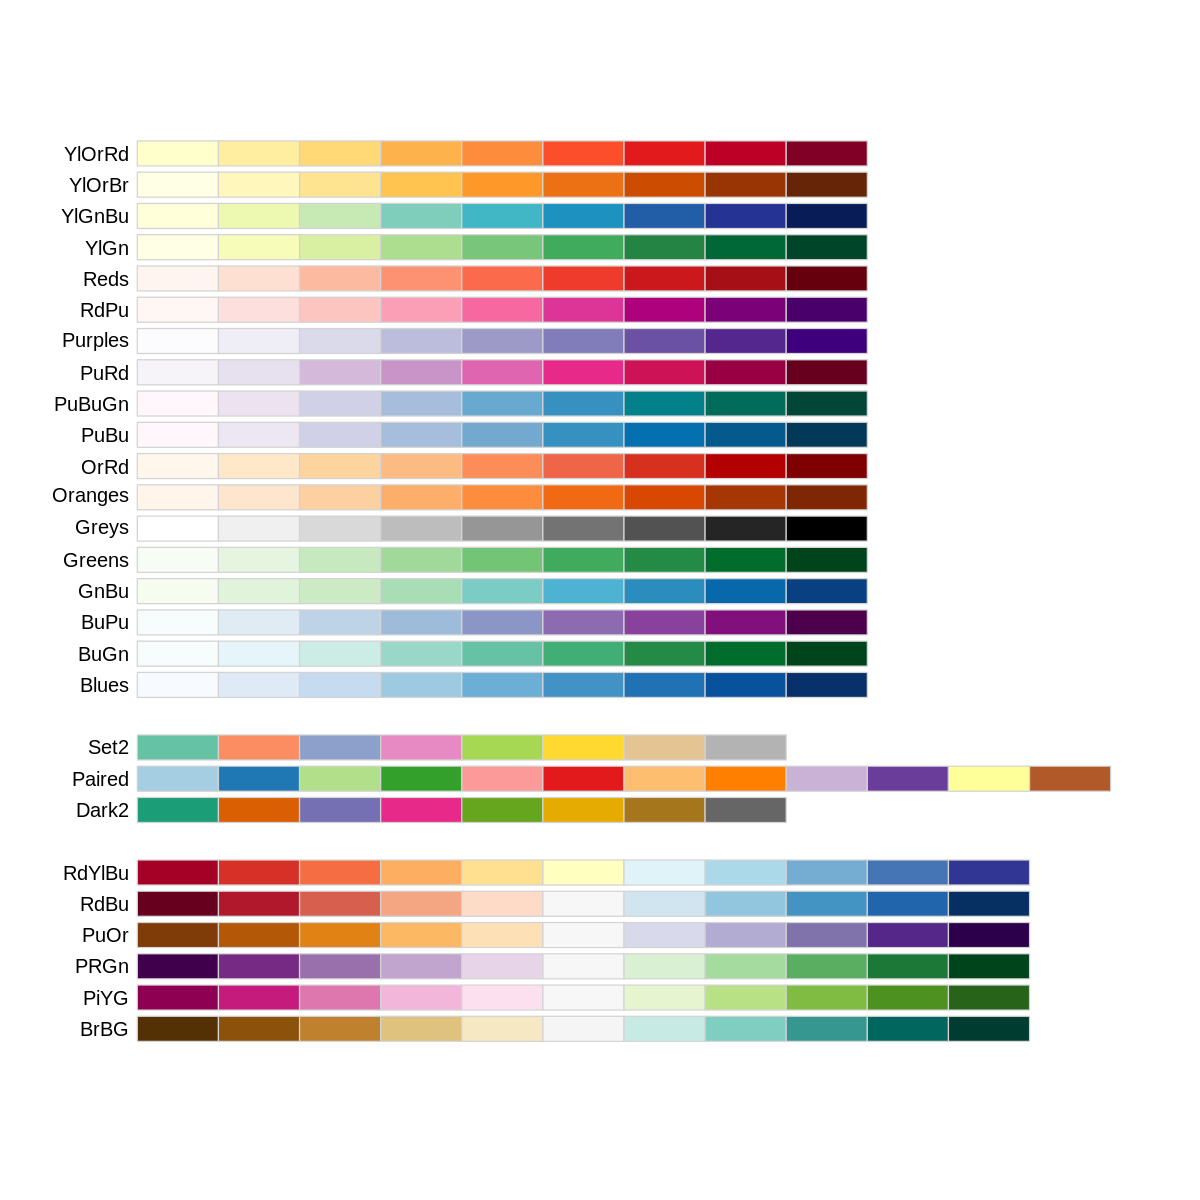

In [79]:
options(repr.plot.width=10, repr.plot.height=10)

# checking colour options to ensure colour blind friendliness of the plots
display.brewer.all(colorblindFriendly = TRUE)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



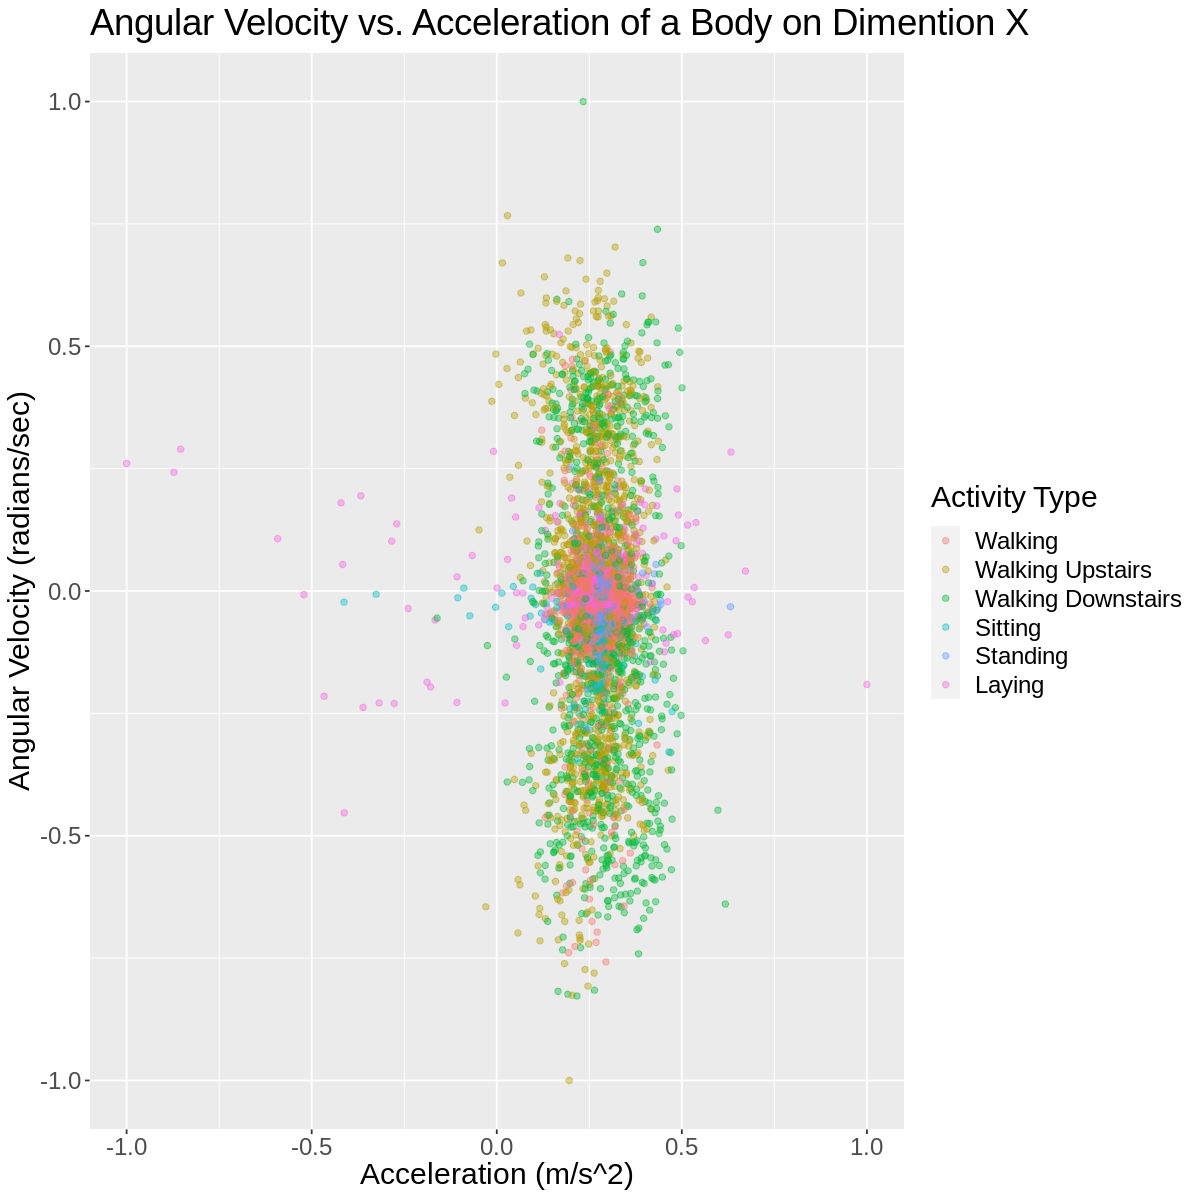

In [88]:
#  Using only training data, compares the distributions of each of the predictor variables

#Plot 1: Angular Velocity vs. Acceleration of a Body on Dimention X
accl_gyro_x <- training_subset %>%
  ggplot(aes(x = tBodyAcc_mean_X, y = tBodyGyro_mean_X, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimention X") +
  geom_point(alpha = 0.4) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("Walking", "Walking Upstairs", "Walking Downstairs", "Sitting", "Standing", "Laying")) +
  theme(text = element_text(size = 18), plot.title = element_text(size=22))

accl_gyro_x

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



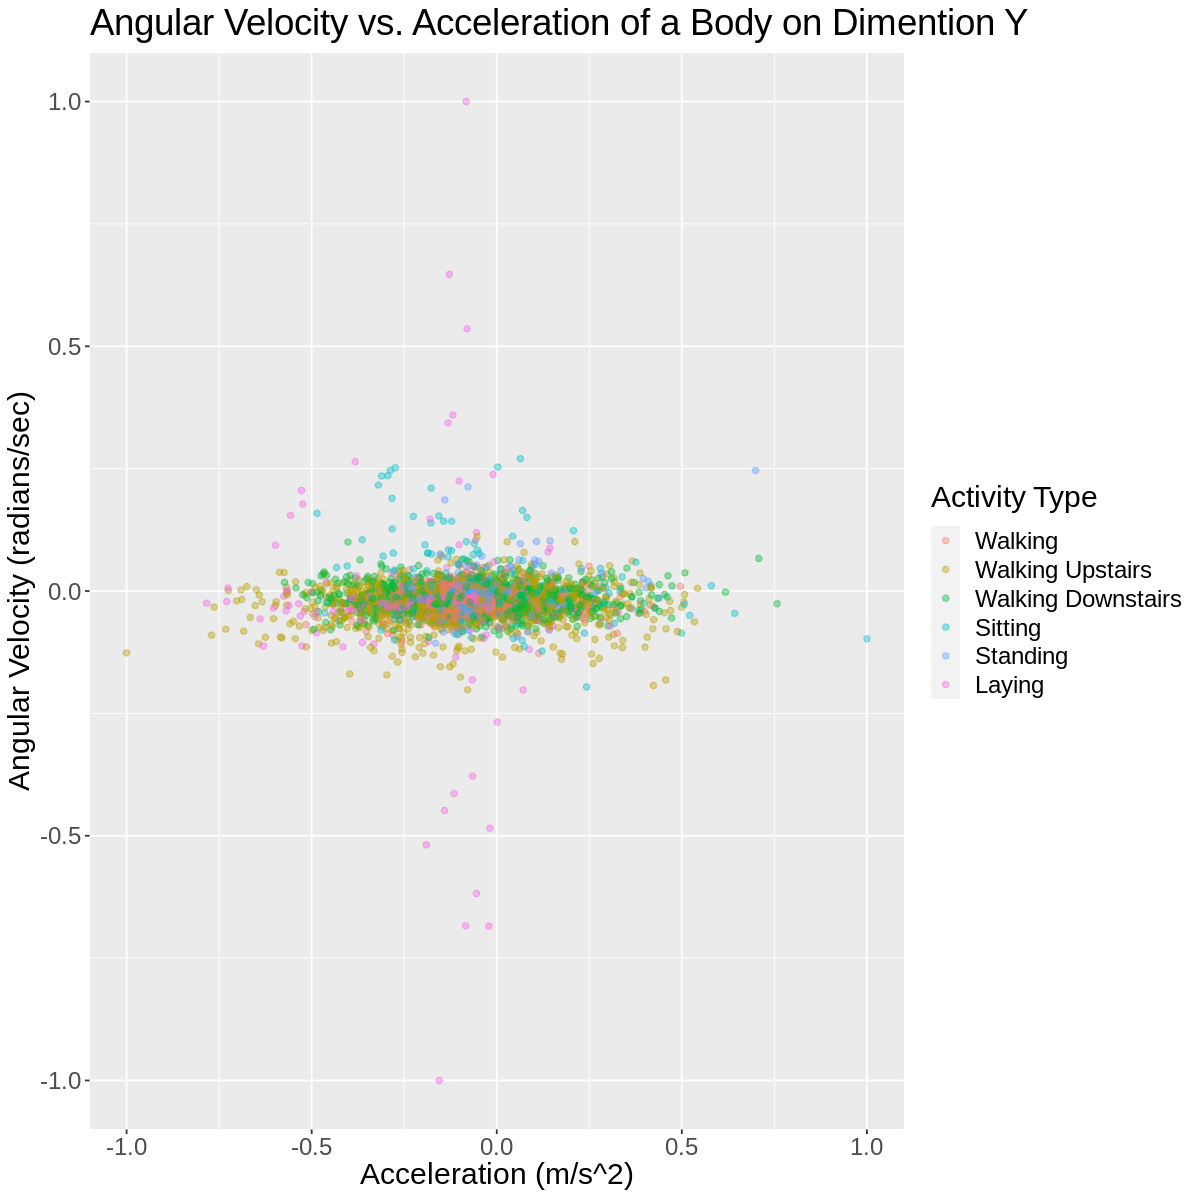

In [89]:
# Plot 2: Angular Velocity vs. Acceleration of a Body on Dimention Y
accl_gyro_y <- training_subset %>%
  ggplot(aes(x = tBodyGyro_mean_Y, y = tBodyAcc_mean_Y, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimention Y") +
  geom_point(alpha = 0.4) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("Walking", "Walking Upstairs", "Walking Downstairs", "Sitting", "Standing", "Laying")) +
  theme(text = element_text(size = 18), plot.title = element_text(size=22))

accl_gyro_y

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



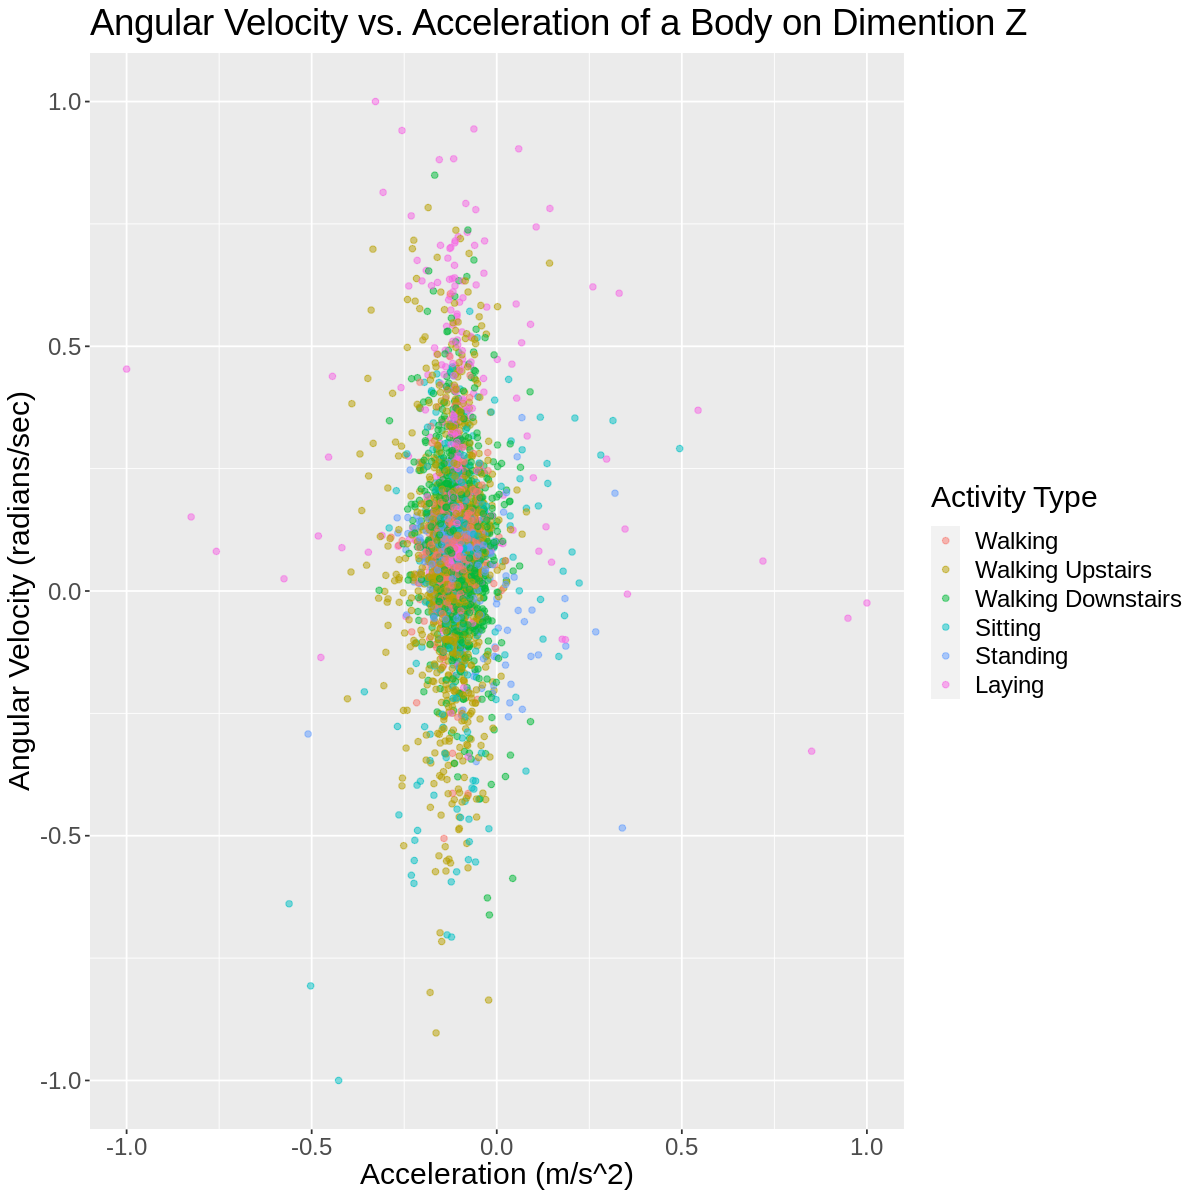

In [90]:
accl_gyro_z <- training_subset %>%
  ggplot(aes(x = tBodyAcc_mean_Z, y = tBodyGyro_mean_Z, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimention Z") +
  geom_point(alpha = 0.5) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("Walking", "Walking Upstairs", "Walking Downstairs", "Sitting", "Standing", "Laying")) +
  theme(text = element_text(size = 18), plot.title = element_text(size=22))

accl_gyro_z